# Классификация изображений. Датасет с симпсонами.

### Установка зависимостей

In [2]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:45tcmalloc: large alloc 1147494400 bytes == 0x656ec000 @  0x7fd7ab149615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 7.0 kB/s 
     |████████████████████████████████| 24.3 MB 1.3 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 849 kB 59.5 MB/s 
     |████████████████████████████████| 317.1 MB 30 kB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully unin

In [1]:
# установка подходящей версии torch

from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

torch.cuda.empty_cache()

CUDA is available!  Training on GPU ...


In [3]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.


5.3.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!ls /content/gdrive/

MyDrive


In [6]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 25 12:53 /content/gdrive/MyDrive/journey-springfield.zip


In [7]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [8]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [9]:
!ls train
!ls testset

simpsons_dataset
testset


In [10]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

unzip:  cannot find or open /content/gdrive/My Drive/simpsons/data/dataset.zip, /content/gdrive/My Drive/simpsons/data/dataset.zip.zip or /content/gdrive/My Drive/simpsons/data/dataset.zip.ZIP.
unzip:  cannot find or open /content/gdrive/My Drive/simpsons/data/testset.zip, /content/gdrive/My Drive/simpsons/data/testset.zip.zip or /content/gdrive/My Drive/simpsons/data/testset.zip.ZIP.


In [11]:
!ls train

simpsons_dataset


In [12]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov 29 19:50:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [14]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")


In [15]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            self.transform = transform
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
          return x
        else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [18]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) 
print(len(test_files)) 

20933
991


In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на героев внутри датасета.

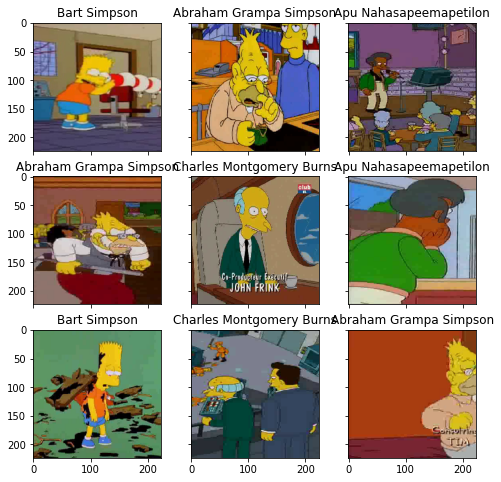

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

In [41]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn2 = nn.BatchNorm2d(32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn3 = nn.BatchNorm2d(64)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn4 = nn.BatchNorm2d(96)

        self.fc = nn.Sequential(
            nn.Linear(96 * 5 * 5, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
        )
        self.out = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logits = self.out(x)
        return logits

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [37]:
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
    if sampler is None:
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cuda()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).cpu().numpy()
    return probs

In [26]:
import pandas as pd
from  torch.utils.data.sampler import WeightedRandomSampler

train_labels = [path.parent.name for path in train_files]
tr_labels_count = pd.Series(train_labels).value_counts()
tr_labels_count

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
charles_montgomery_burns     895
principal_skinner            895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
mayor_quimby                 185
waylon_smithers              136
maggie_simpson                96
groundskeeper_willie          91
barney_gumble                 80
selma_bouvier                 77
carl_carlson                  74
ralph_wiggum                  67
patty_bouvier                 54
martin_prince                 53
professor_john_frink          49
snake_jail

In [27]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(hue=0.1, saturation=0.1),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]) 

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train', transform = transform)

In [29]:
class_weights = {label: 1./c for label, c in tr_labels_count.items()}
class_weights
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_1 = train_dataset.label_encoder.inverse_transform([label])[0]
    class_weight = class_weights.get(label_1)
    sample_weights[i] = class_weight


sampler = WeightedRandomSampler(sample_weights, num_samples = 2*len(train_dataset))

100%|██████████| 15699/15699 [04:59<00:00, 52.36it/s]


In [43]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [32]:
from torchvision import transforms, models

In [33]:
model_alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [34]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [39]:
# model_alexnet.classifier = nn.Sequential(
#             nn.Linear(9216, 2048),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(2048, 2048),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(2048, n_classes),
#         )

for param in model_alexnet.parameters():
    param.requires_grad = False
model_alexnet.classifier[-1] = nn.Linear(4096, n_classes)
model_alexnet = model_alexnet.to(DEVICE)

Запустим обучение сети.

In [44]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=12, batch_size=64, sampler=sampler)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 1.5961141454557666


epoch:   8%|▊         | 1/12 [10:46<1:58:31, 646.47s/it]


Epoch 001 train_loss: 1.5961     val_loss 1.5788 train_acc 0.5743 val_acc 0.5757
loss 0.6869400093354832


epoch:  17%|█▋        | 2/12 [21:27<1:47:11, 643.11s/it]


Epoch 002 train_loss: 0.6869     val_loss 1.2254 train_acc 0.8099 val_acc 0.6935
loss 0.4632619767232612


epoch:  25%|██▌       | 3/12 [32:05<1:36:08, 640.90s/it]


Epoch 003 train_loss: 0.4633     val_loss 1.1564 train_acc 0.8683 val_acc 0.7170
loss 0.38565651769166964


epoch:  33%|███▎      | 4/12 [42:45<1:25:23, 640.44s/it]


Epoch 004 train_loss: 0.3857     val_loss 1.0029 train_acc 0.8901 val_acc 0.7516
loss 0.3440065741371946


epoch:  42%|████▏     | 5/12 [53:24<1:14:39, 639.90s/it]


Epoch 005 train_loss: 0.3440     val_loss 1.0035 train_acc 0.9017 val_acc 0.7583
loss 0.2976893146556573


epoch:  50%|█████     | 6/12 [1:03:59<1:03:49, 638.21s/it]


Epoch 006 train_loss: 0.2977     val_loss 0.9893 train_acc 0.9168 val_acc 0.7734
loss 0.24954281102279105


epoch:  58%|█████▊    | 7/12 [1:14:28<52:56, 635.25s/it]


Epoch 007 train_loss: 0.2495     val_loss 1.0320 train_acc 0.9282 val_acc 0.7717
loss 0.25321383847747003


epoch:  67%|██████▋   | 8/12 [1:24:57<42:12, 633.18s/it]


Epoch 008 train_loss: 0.2532     val_loss 0.9808 train_acc 0.9280 val_acc 0.7896
loss 0.21559705757707143


epoch:  75%|███████▌  | 9/12 [1:35:28<31:37, 632.60s/it]


Epoch 009 train_loss: 0.2156     val_loss 0.9650 train_acc 0.9407 val_acc 0.7822
loss 0.21509490460223837


epoch:  83%|████████▎ | 10/12 [1:46:12<21:12, 636.28s/it]


Epoch 010 train_loss: 0.2151     val_loss 0.9314 train_acc 0.9397 val_acc 0.8013
loss 0.19906156362090205


epoch:  92%|█████████▏| 11/12 [1:56:45<10:35, 635.05s/it]


Epoch 011 train_loss: 0.1991     val_loss 0.9759 train_acc 0.9447 val_acc 0.8019
loss 0.17201633561319268


epoch: 100%|██████████| 12/12 [2:07:18<00:00, 636.58s/it]


Epoch 012 train_loss: 0.1720     val_loss 0.8743 train_acc 0.9505 val_acc 0.8036


Построим кривые обучения

In [45]:
loss, acc, val_loss, val_acc = zip(*history)

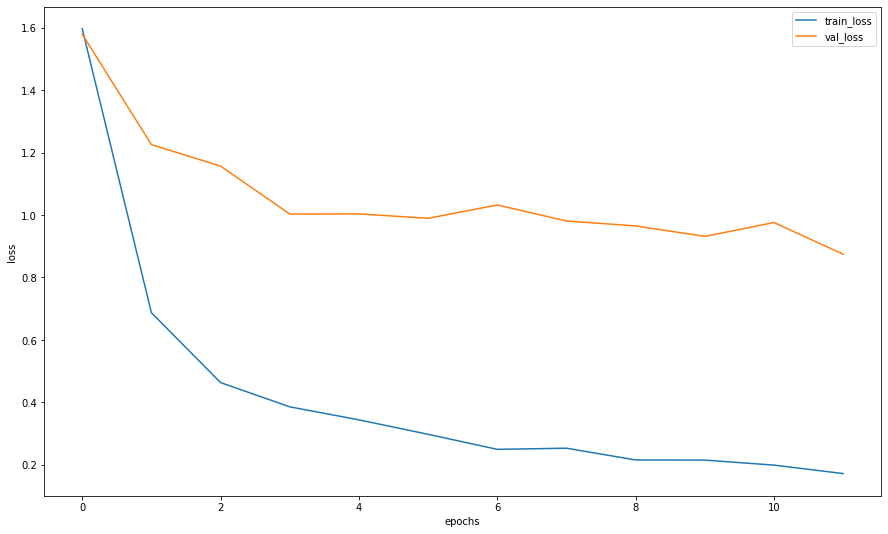

In [46]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [47]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [48]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [49]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [50]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [51]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [52]:
actual_labels

[0, 6, 4, 4, 0, 3, 4, 5, 0, 6, 4, 6, 0, 6, 2, 4, 2, 6, 4, 4]

In [53]:
len(y_pred) == len(actual_labels)

True

In [54]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.85

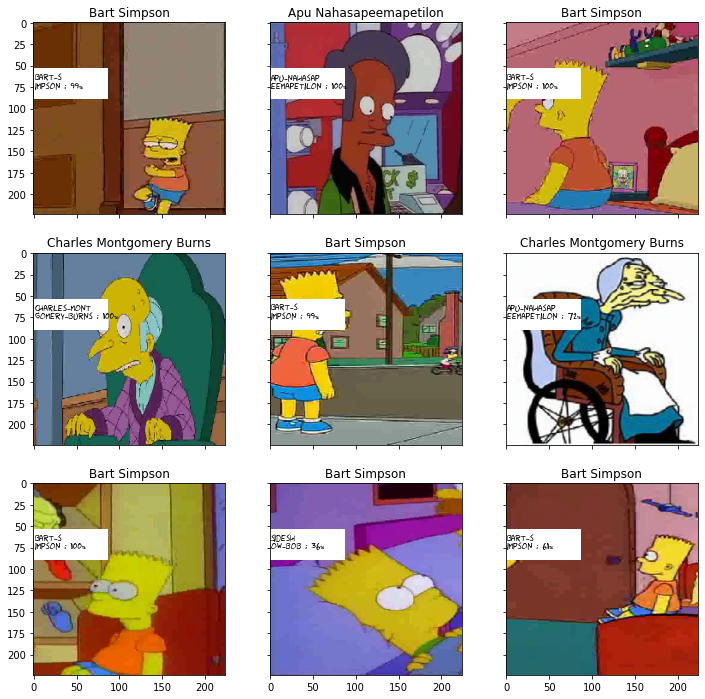

In [55]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [56]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [57]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [58]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [59]:
my_submit.to_csv('simple_cnn_baseline_4.csv', index=False)